<a href="https://colab.research.google.com/github/meichenfang/Poisson-regression/blob/main/find-weight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

**Denote the gene expression matrix by $X_{ij}$ where j is gene index and i is cell index. In summary, we assume a specific model of transcription and want to solve**

\begin{align}
    & \text{argmax}_{\theta_j} \sum_{j} \sum_i \ln P(\mathcal{X}_{ij},t_i; \theta_j,\tau).
\end{align}

We assume t follows a uniform distribution on [0,1]. We use alternative minimization/EM-like algorithm to find optimal θ.

In [ ]:
import time
from order_functions import *

## EM_functions.py

In [90]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Jun 16 21:20:50 2022

@author: Meichen Fang
"""

import numpy as np
from tqdm import tqdm
from multiprocessing import Pool
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# global parameters: upper and lower limits for numerical stability
eps = 1e-10
omega = -1e6

def get_Y(theta, t, tau):
    # theta: p*(K+4)
    # t: len m
    # tau: len K+1
    # return m * p * 2
    p = len(theta)
    K = len(tau)-1 # number of states
    if np.shape(theta)[1]!=K+4:
      raise TypeError("wrong parameters lengths")
    a = theta[:,0:K]
    beta = theta[:,-2]
    gamma = theta[:,-1]

    y1_0 = theta[:,-4]
    y2_0 = theta[:,-3]

    c = beta/(beta-gamma+eps)
    d = beta**2/((beta-gamma)*gamma+eps)
    y_0 = y2_0 + c*y1_0
    a_ = d[:,None]*a
    t = t.reshape(-1,1)
    m = len(t)
  
    I = np.ones((K+1,m),dtype=bool)
    y1 =np.zeros((m,p))
    y =np.zeros((m,p))

    # nascent
    y1=y1+y1_0[None,:]*np.exp(-beta[None,:]*t)   
    for k in range(1,K+1):
      I[k] = np.squeeze(t > tau[k])
      idx =I[k-1]*(~I[k]) # tau_{k-1} < t_i <= tau_k
      y1[I[k],:] = y1[I[k],:] + a[None,:,k-1] * (np.exp(- beta[None,:]*(t[I[k]]-tau[k]))- np.exp(-beta[None,:]* (t[I[k]]-tau[k-1])) ) 
      y1[idx,:] = y1[idx,:] + a[None,:,k-1] * (1 - np.exp(- beta[None,:] *(t[idx]-tau[k-1]))) 
    
    if np.sum(np.isnan(y1)) != 0:
        raise ValueError("Nan in y1")
    # mature + c * nascent 
    y=y+y_0[None,:]*np.exp(-gamma[None,:]*t)    
    for k in range(1,K+1):
      idx =I[k-1]*(~I[k]) # tau_{k-1} < t_i <= tau_k
      y[I[k]] = y[I[k]] + a_[None,:,k-1] * (np.exp(-gamma[None,:] * (t[I[k]]-tau[k]))- np.exp(-gamma[None,:]*(t[I[k]]-tau[k-1])) )
      y[idx] = y[idx] +  a_[None,:,k-1] * (1 - np.exp(-gamma[None,:]*(t[idx]-tau[k-1]))) 

    if np.sum(np.isnan(y)) != 0:
        raise ValueError("Nan in y")
    Y =np.zeros((m,p,2))
    Y[:,:,0] = y1
    Y[:,:,1] = y-c*y1
    
    Y[Y<0]=0
    
    if np.sum(np.isnan(Y)) != 0:
        raise ValueError("Nan in Y")
    return Y

def neglogL_L1(log_theta,x,weight,t,tau,penalty=0):
    # theta: length K+4
    # x: n*2
    # weight: n*m
    # t: len m
    # tau: len K+1
    K=len(tau)-1
    theta = np.exp(log_theta)
    Y = get_Y(theta[None,:],t,tau) # m*1*2
    Y = Y[None,:,0,:] # 1*m*2
    logL = np.sum( weight[:,:,None] * (x[:,None,:] * np.log( eps + Y) - Y ) )  
    loss = - logL + penalty * ( np.sum(np.abs(theta[0:K]-theta[0])) + np.abs(theta[-4]-theta[0])
                                + np.abs(theta[-3]*theta[-1]/(eps+theta[-2]) - theta[0])  ) 
    return loss

def neglogL(theta,x,weight,t,tau):
    # theta: length K+4
    # x: n*2
    # weight: n*m
    # t: len m
    # tau: len K+1
    Y = get_Y(theta[None,:],t,tau) # m*1*2
    Y = Y[None,:,0,:] # 1*m*2
    logL = np.sum( weight[:,:,None] * (x[:,None,:] * np.log( eps + Y) - Y ) )  
    return - logL
  
def neglogL_bg(theta_bg,theta_a,x,weight,t,tau):
    theta = np.append(theta_a, theta_bg)
    Y = get_Y(theta[None,:],t,tau) # m*1*2
    Y = Y[None,:,0,:] # 1*m*2
    logL = np.sum( weight[:,:,None] * (x[:,None,:] * np.log( eps + Y) - Y ) )  
    return - logL

def neglogL_a(theta_a,theta_bg,x,weight,t,tau):
    theta = np.append(theta_a, theta_bg)
    Y = get_Y(theta[None,:],t,tau) # m*1*2
    Y = Y[None,:,0,:] # 1*m*2
    logL = np.sum( weight[:,:,None] * (x[:,None,:] * np.log( eps + Y) - Y ) )  
    return - logL

def minimize_wrapper(args):
    theta0, x, weight, t, tau = args
    new_theta = np.zeros_like(theta0)
    bds = [[0,10*np.max(x)]]*len(theta0[:-2])

    res = minimize(neglogL_a, theta0[:-2], 
                   args=(theta0[-2:],x,weight,t,tau), 
                   bounds = bds,
                   options={'maxiter':1000,'disp': False}) 
    new_theta[:-2]=res.x
    res = minimize(neglogL_bg, theta0[-2:], 
                   args=(theta0[:-2],x,weight,t,tau), 
                   bounds = [[0.1,10]]*2,
                   options={'maxiter':1000,'disp': False}) 
    new_theta[-2:]=res.x
    return new_theta


def minimize_wrapper_all(args):
    log_theta0, x, weight, t, tau = args
    bounds = [[-np.inf,10]]*len(log_theta0)
    bounds[-2:] = [[-2,10]]*2
    res = minimize(neglogL, log_theta0, args=(x,weight,t,tau), bounds=bounds, options={'maxiter':1000,'disp': False}) 
    return res.x

def update_theta_all(X,weight,tau,parallel=False,n_threads=1,theta0=None):
    n,p,s=np.shape(X)
    if s!=2:
      raise TypeError("wrong parameters lengths")
    n,m=np.shape(weight)
    t=np.linspace(0,1,m)
    K=len(tau)-1

    if theta0 is None:
        theta0 = 10*np.ones((p,K+4))
        theta0[:,0:(K+2)]=np.mean(X[:,:,0],axis=0)[:,None]
        #gamma_hat = np.mean(X[:,:,0],axis=0)/(np.mean(X[:,:,1],axis=0)+eps)
        #theta0[:,-1] = gamma_hat

    if parallel is True:
        Input_args = []
        for i in range(p):
            Input_args.append((np.log(theta0[i]), X[:,i], weight, t, tau))
        with Pool(n_threads) as pool:      
            log_theta_hat = pool.map(minimize_wrapper_all, Input_args)
        log_theta_hat = np.array(log_theta_hat)
    else:
        log_theta_hat = np.zeros((p,K+4))
        for i in range(p): 
            args = (np.log(theta0[i]), X[:,i], weight, t, tau) 
            log_theta_hat[i]=minimize_wrapper(args)
    return np.exp(log_theta_hat)

def update_theta(X,weight,tau,parallel=False,n_threads=1,theta0=None):
    n,p,s=np.shape(X)
    if s!=2:
      raise TypeError("wrong parameters lengths")
    n,m=np.shape(weight)
    t=np.linspace(0,1,m)
    K=len(tau)-1

    if theta0 is None:
        theta0 = 10*np.ones((p,K+4))
        theta0[:,0:(K+2)]=np.mean(X[:,:,0],axis=0)[:,None]
        #gamma_hat = np.mean(X[:,:,0],axis=0)/(np.mean(X[:,:,1],axis=0)+eps)
        #theta0[:,-1] = gamma_hat

    if parallel is True:
        Input_args = []
        for i in range(p):
            Input_args.append((np.log(theta0[i]), X[:,i], weight, t, tau))
        with Pool(n_threads) as pool:      
            log_theta_hat = pool.map(minimize_wrapper, Input_args)
        log_theta_hat = np.array(log_theta_hat)
    else:
        log_theta_hat = np.zeros((p,K+4))
        for i in range(p): 
            args = (np.log(theta0[i]), X[:,i], weight, t, tau) 
            log_theta_hat[i]=minimize_wrapper(args)
    return np.exp(log_theta_hat)

def update_weight(X,theta,tau,m):
    n,p,s=np.shape(X)
    t=np.linspace(0,1,m)
    Y = get_Y(theta,t,tau) # m*p*2
    Y = Y[None,:,:,:] # 1*m*p*2
    logL =  np.sum(X[:,None,:,:] * np.log(Y+eps) - Y, axis=(2,3)) # n*m*p*2 -> n*m
    w = np.zeros((n,m))
    for i in range(n):
        c = np.max(logL[i,:])
        relative_logL = logL[i,:]-c        
        relative_logL[relative_logL<omega]=omega
        L = np.exp(relative_logL)
        w[i,:] = L/L.sum()
    if np.sum(np.isnan(w)) != 0:
        raise ValueError("Nan in weight")
    return w

def traj_EM(X, tau, m=101, epoch=20, parallel=False, n_threads=1):
    """
    X: n cells * p genes
    m grid of t=[0,1]
    """
    eps = 10**(-10)
    n,p,_=np.shape(X)
    K=len(tau)-1
    theta_hat = np.ones((p,K+4))
    theta_hat[:,0:K]=np.mean(X[:,:,0],axis=0)[:,None]
    weight=np.ones((n,m))/m
    theta_hist=[]
    weight_hist=[]
    for i in tqdm(range(epoch)):
        theta_hat = update_theta(X,weight,tau,theta0=theta_hat,parallel=parallel,n_threads=n_threads)
        weight = update_weight(X,theta_hat,tau,m)
        theta_hist.append(theta_hat)
        weight_hist.append(weight)
    return theta_hist, weight_hist



## plot functions

In [91]:
def plot_t(weight,ax=None,t=None):
    m=np.shape(weight)[1]
    h=np.linspace(0,1,m)
    t_hat=np.sum(weight*h[None,:],axis=1)
    if ax is None:
        fig, ax = plt.subplots(1,1)
    if t is not None:
        ord=np.argsort(t)
        # build a rectangle in axes coords
        left, width = .25, .5
        bottom, height = .25, .5
        right = left + width
        top = bottom + height
       
        ax.imshow(weight[ord,:],aspect="auto");
        ax.text(right, top,"cor="+str(np.around(np.corrcoef(t_hat,t)[0,1],2)), horizontalalignment='right', 
                 verticalalignment='top', transform=ax.transAxes, color="white");
    else:
        ord=np.argsort(t_hat)
        ax.imshow(weight[ord,:],aspect="auto");

def plot_theta(theta,theta_hat):
    K=np.shape(theta)[1]-4
    fig, ax = plt.subplots(1,K+4,figsize=(6*(K+4),4))

    for i in range(K):
        ax[i].plot(theta[:,i],theta[:,i]);
        ax[i].plot(theta[:,i],theta_hat[:,i],'.');
        ax[i].set_title("a"+str(i+1))
        ax[i].set_xlabel("true values")

    ax[-4].plot(theta[:,-4],theta[:,-4]);
    ax[-4].plot(theta[:,-4],theta_hat[:,-4],'.');
    ax[-4].set_title("u0")
    ax[-4].set_ylabel("fitted values")
    ax[-4].set_xlabel("true values")

    ax[-3].plot(theta[:,-3],theta[:,-3]);
    ax[-3].plot(theta[:,-3],theta_hat[:,-3],'.');
    ax[-3].set_title("s0")
    ax[-3].set_ylabel("fitted values")
    ax[-3].set_xlabel("true values")

    ax[-2].plot(theta[:,-2],theta[:,-2]);
    ax[-2].plot(theta[:,-2],theta_hat[:,-2],'.');
    ax[-2].set_title("beta");
    ax[-2].set_xlabel("true values");

    ax[-1].plot(theta[:,-1],theta[:,-1]);
    ax[-1].plot(theta[:,-1],theta_hat[:,-1],'.');
    ax[-1].set_title("gamma");
    ax[-1].set_xlabel("true values");


def plot_theta_hat(theta_hat,K,gene_list):
    fig, ax = plt.subplots(K+4,1,figsize=(12,4*(K+4)))

    for i in range(K+4):
        ax[i].scatter(np.array(gene_list), np.log(theta_hat[:,i]));

    ax[0].set_title("log a1");
    ax[1].set_title("log a2");
    ax[2].set_title("log u0");
    ax[3].set_title("log s0");
    ax[4].set_title("log beta");
    ax[5].set_title("log gamma");


def plot_y(theta,theta_hat,weight,tau,gene_list):
    m=np.shape(weight)[1]
    p=np.shape(theta_hat)[0]
    h=np.linspace(0,1,m)
    t_hat=np.sum(weight*h[None,:],axis=1)
    y_hat = get_Y(theta_hat, t_hat, tau)
    y = get_Y(theta, t_hat, tau)
    fig, ax = plt.subplots(p,2,figsize=(12,4*p))
    for i in range(p):
        ax[i,0].plot(t_hat,X[:,i,0],'.',color="gray");
        ax[i,0].plot(t_hat,y_hat[:,i,0],'b.');
        ax[i,0].plot(t_hat,y[:,i,0],'r.');
        ax[i,0].set_title(gene_list[i]+" unspliced")

        ax[i,1].plot(t_hat,X[:,i,1],'.',color="gray");
        ax[i,1].plot(t_hat,y_hat[:,i,1],'b.');
        ax[i,1].plot(t_hat,y[:,i,1],'r.');
        ax[i,1].set_title(gene_list[i]+" spliced")



# Test

## Given true time, it's able to estimate theta

In [92]:
#%% generate data
np.random.seed(2022)
n = 1000
p = 10
Tau=[0,0.5]
tau=(0,0.5,1)
K=len(tau)-1
t = np.linspace(0, 1, n)

theta=np.zeros((p,K+4))
theta[:,0]=np.exp(np.random.uniform(0,4,size=p))
theta[:,1]=np.exp(np.random.uniform(0,4,size=p))
theta[:,-3]=np.exp(np.random.uniform(0,4,size=p))
theta[:,-4]=np.exp(np.random.uniform(0,4,size=p))
theta[:,-1]=np.exp(np.random.uniform(0,2,size=p))
theta[:,-2]=np.exp(np.random.uniform(0,2,size=p))


%time Y = get_Y(theta,t,tau)

X = np.random.poisson(Y)

CPU times: user 2.71 ms, sys: 0 ns, total: 2.71 ms
Wall time: 2.72 ms


In [93]:
#%% update theta
weight=np.diag(v=[1]*n)
%time theta_hat=update_theta(X,weight,tau,parallel=True,n_threads=2,theta0=None)

CPU times: user 956 ms, sys: 209 ms, total: 1.17 s
Wall time: 2min 2s


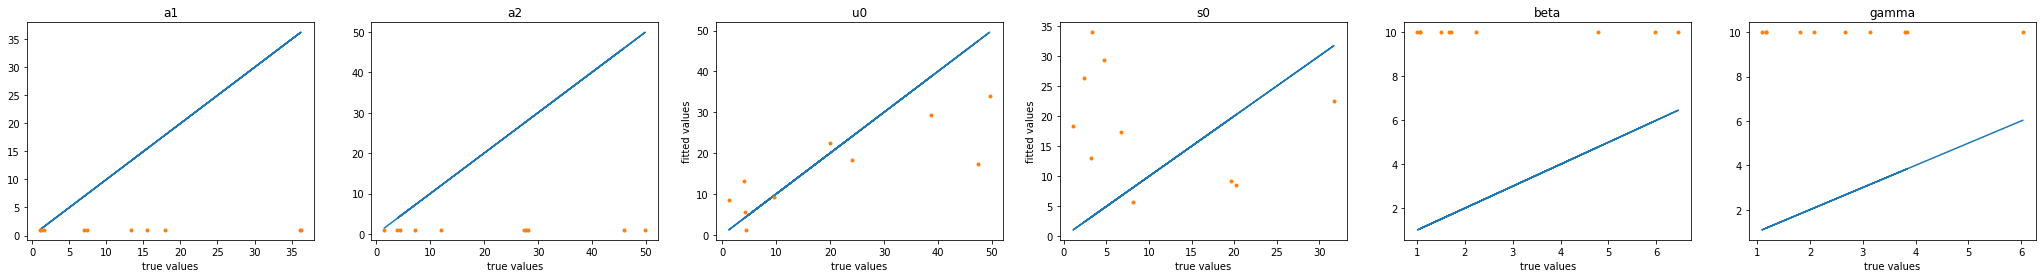

In [94]:
plot_theta(theta[:,],theta_hat)

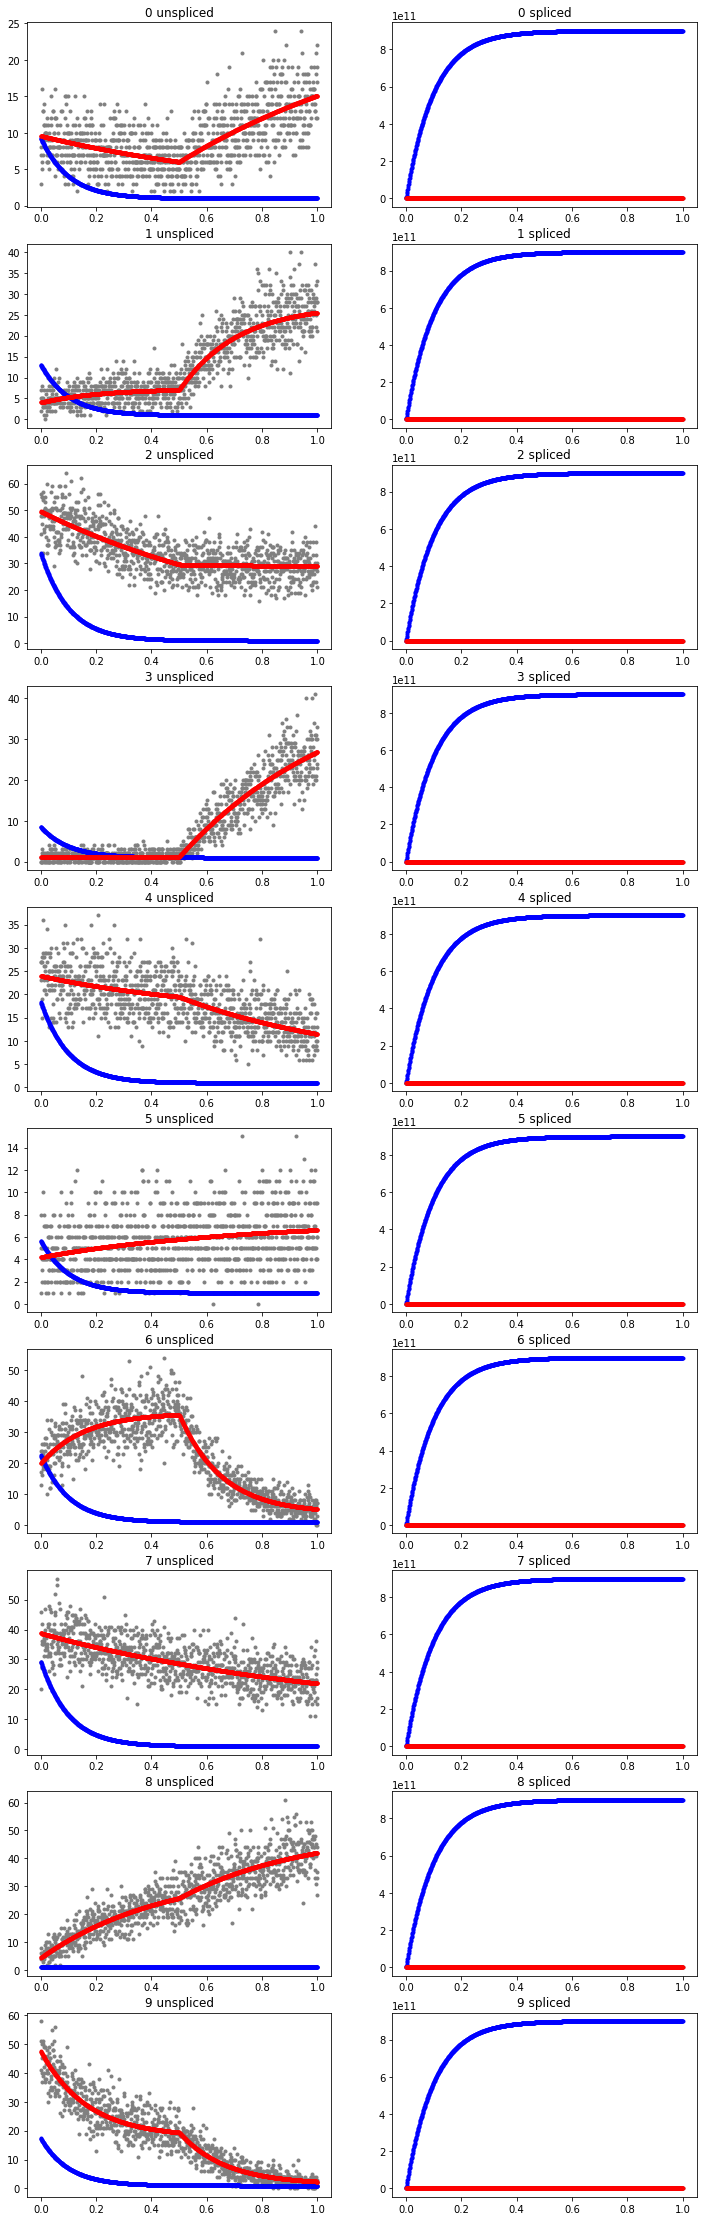

In [95]:
plot_y(theta,theta_hat,weight,tau,[str(i) for i in range(p)])

In [96]:
#%% update theta
weight=np.diag(v=[1]*n)
%time theta_hat=update_theta_all(X,weight,tau,parallel=True,n_threads=2,theta0=None)

CPU times: user 1.16 s, sys: 259 ms, total: 1.42 s
Wall time: 2min 29s


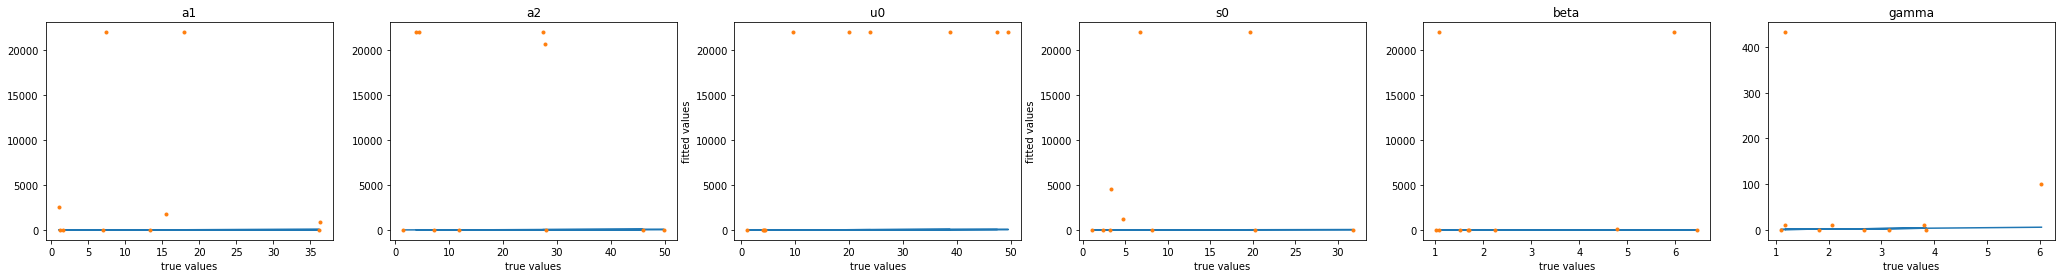

In [97]:
plot_theta(theta[:,],theta_hat)

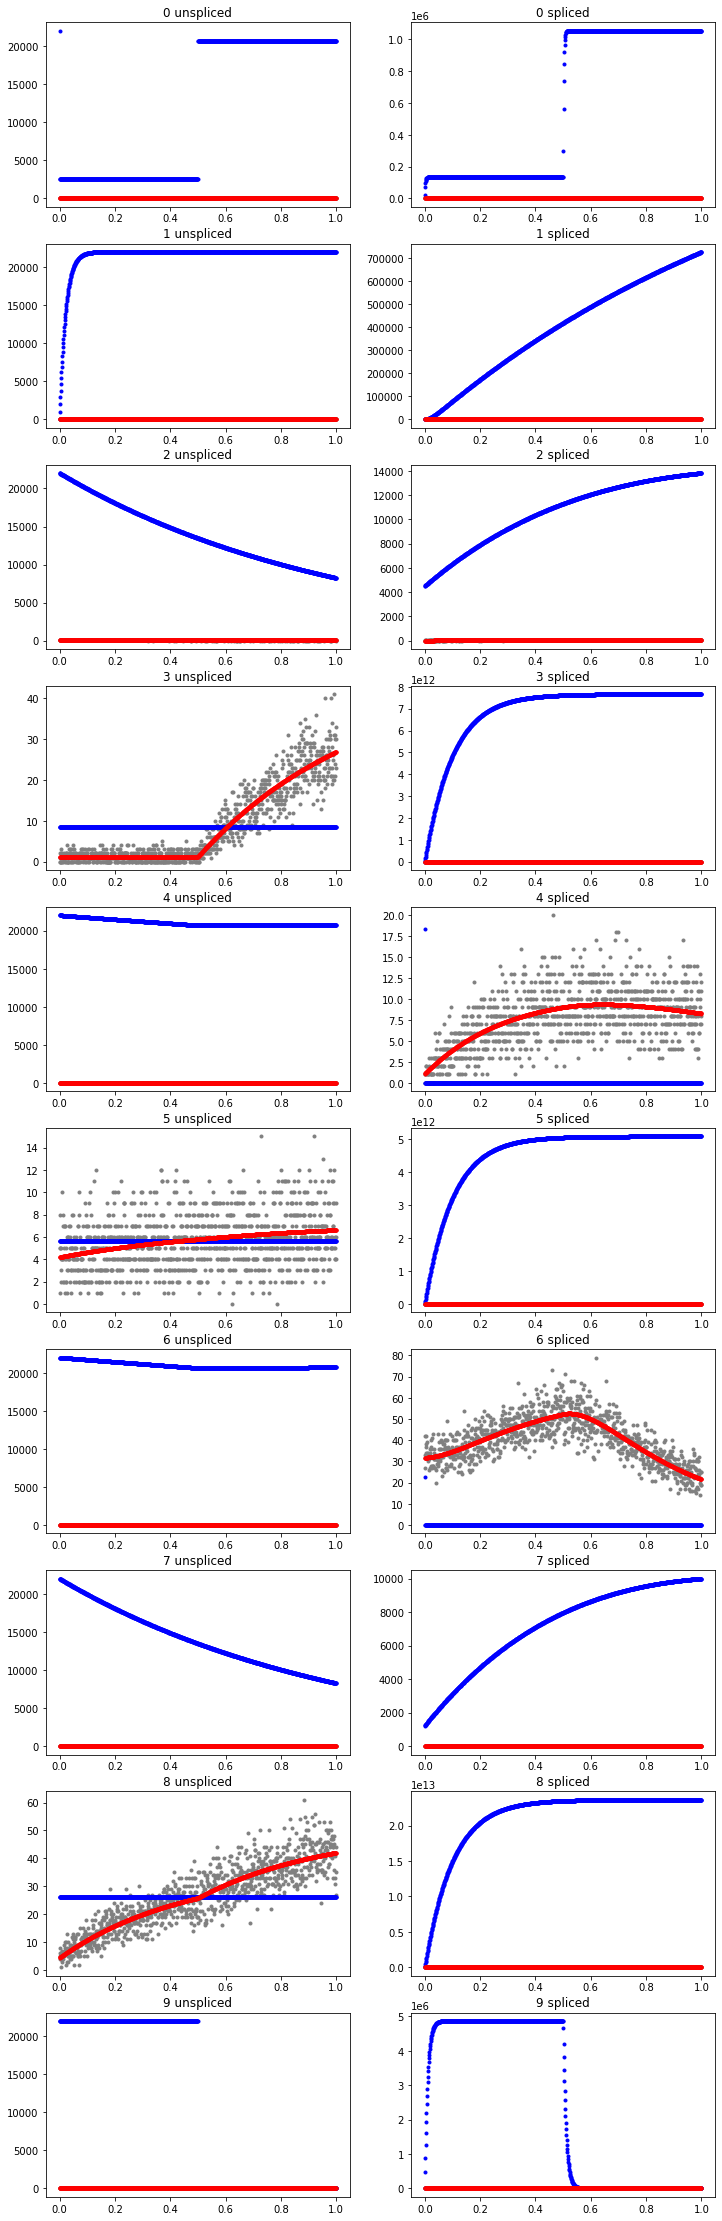

In [98]:
plot_y(theta,theta_hat,weight,tau,[str(i) for i in range(p)])

## Given true theta, it's able to find reasonable posterior

In [35]:
m=1001
weight = update_weight(X,theta,tau,m)

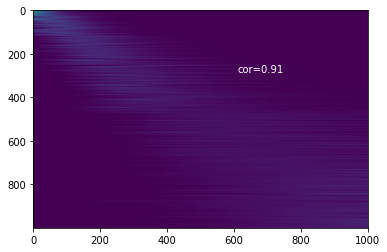

In [36]:
plot_t(weight, ax=None, t=t)

## traj_EM

### Close look at one example

In [12]:
#%% generate data
np.random.seed(2022)
n = 1000
p = 10
u0 = np.random.uniform(0,10,size=p)
s0 = np.random.uniform(0,10,size=p)
a1 = np.random.uniform(0,10,size=p)
a2 = np.random.uniform(0,10,size=p)
beta = np.random.uniform(1,5,size=p)
gamma = np.random.uniform(1,5,size=p)

t = np.linspace(0, 1, n)

Tau=[0,0.5]
tau=(0,0.5,1)

K=len(tau)-1
theta=np.zeros((p,K+4))
theta[:,0]=a1
theta[:,1]=a2
theta[:,-3]=s0
theta[:,-4]=u0
theta[:,-1]=gamma
theta[:,-2]=beta

Y = get_Y(theta,t,tau)

X = np.random.poisson(Y)

%time theta_hat_hist, weight_hist = traj_EM(X, tau, m=101, epoch=20, parallel = True, n_threads = 2)

100%|██████████| 20/20 [06:43<00:00, 20.17s/it]

CPU times: user 3.83 s, sys: 1.01 s, total: 4.83 s
Wall time: 6min 43s


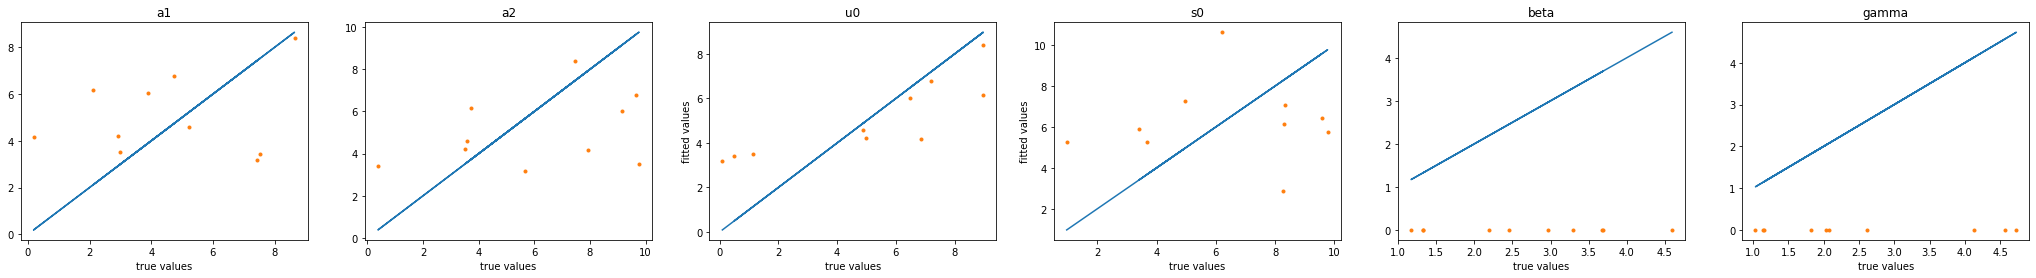

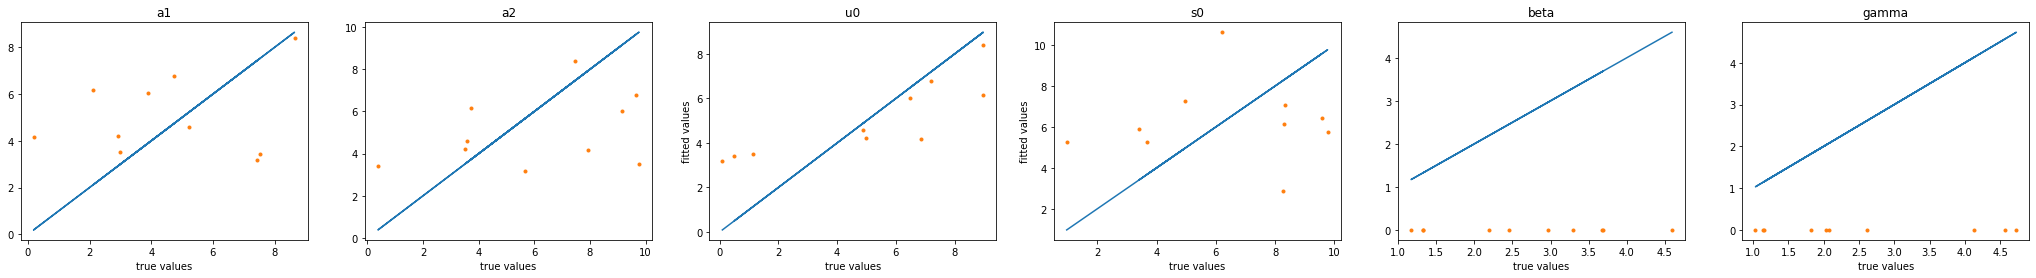

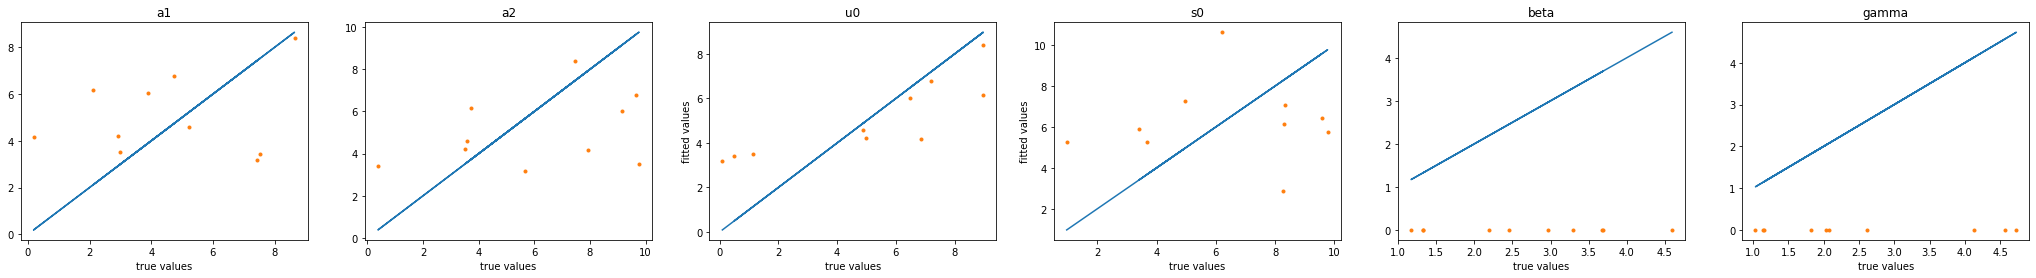

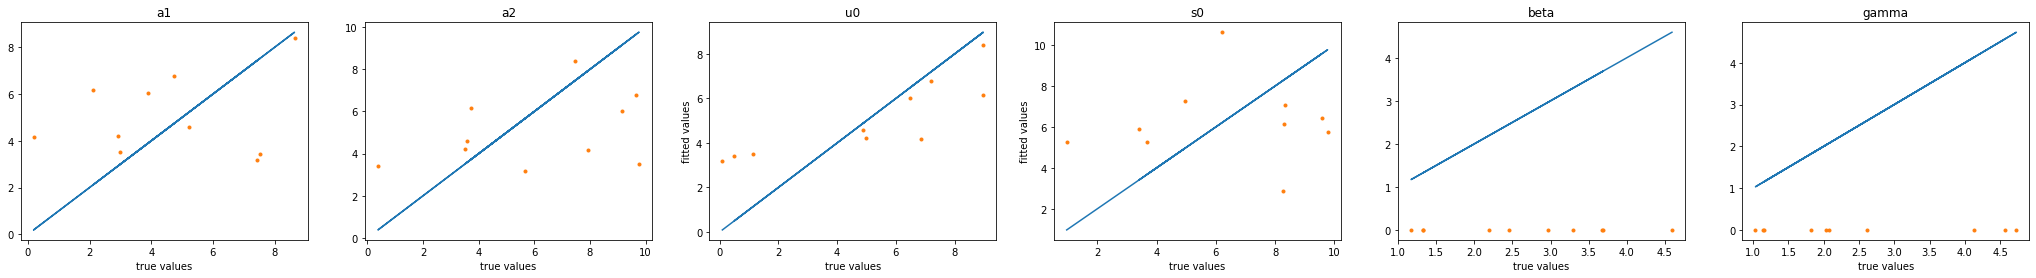

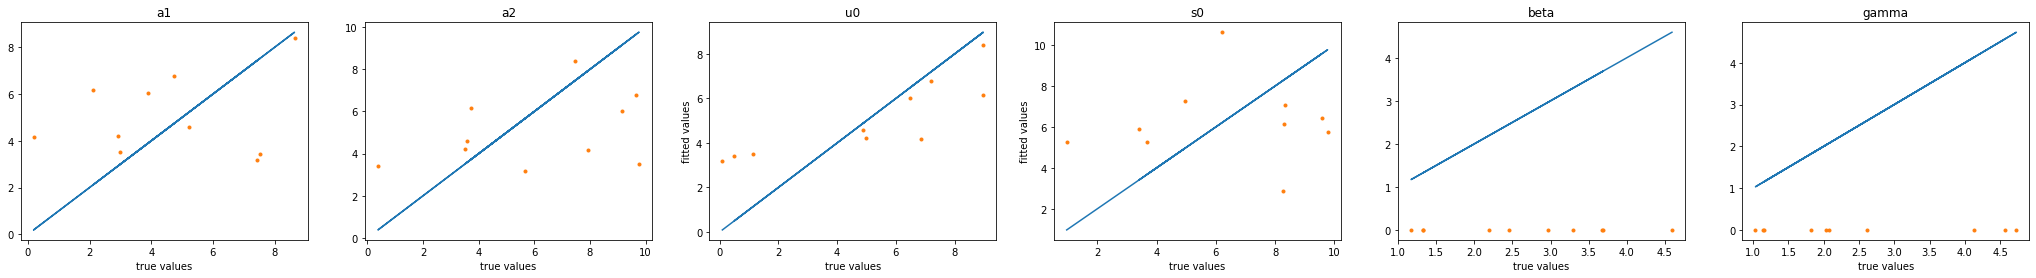

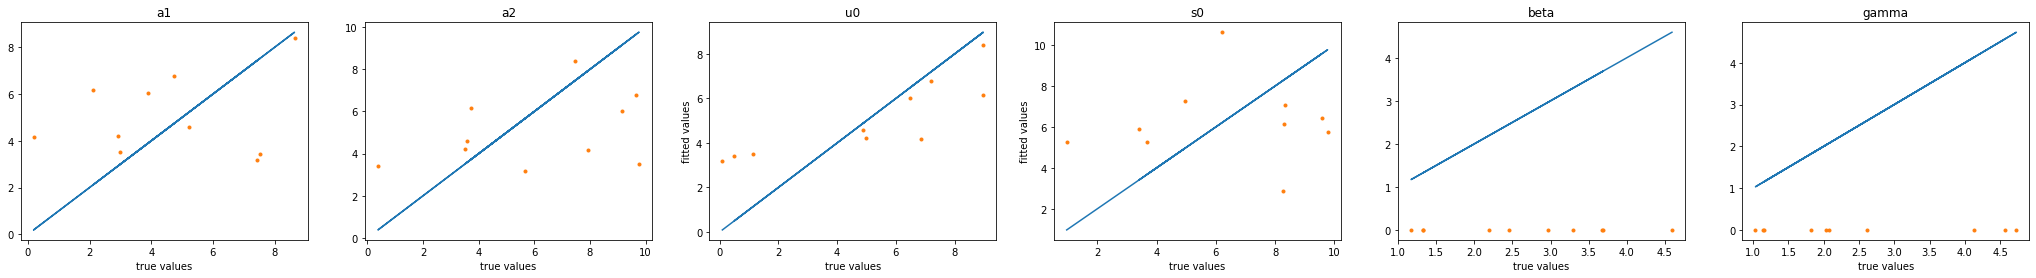

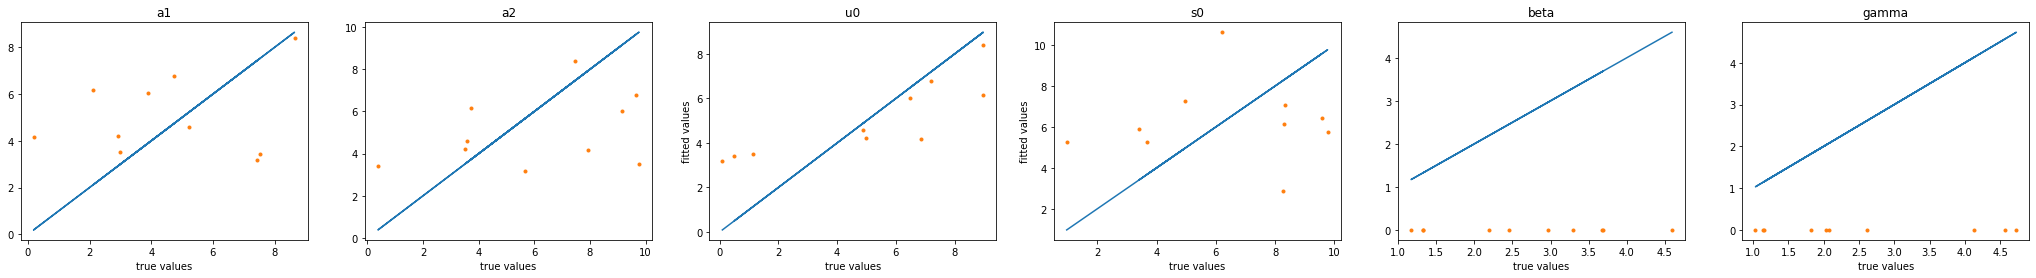

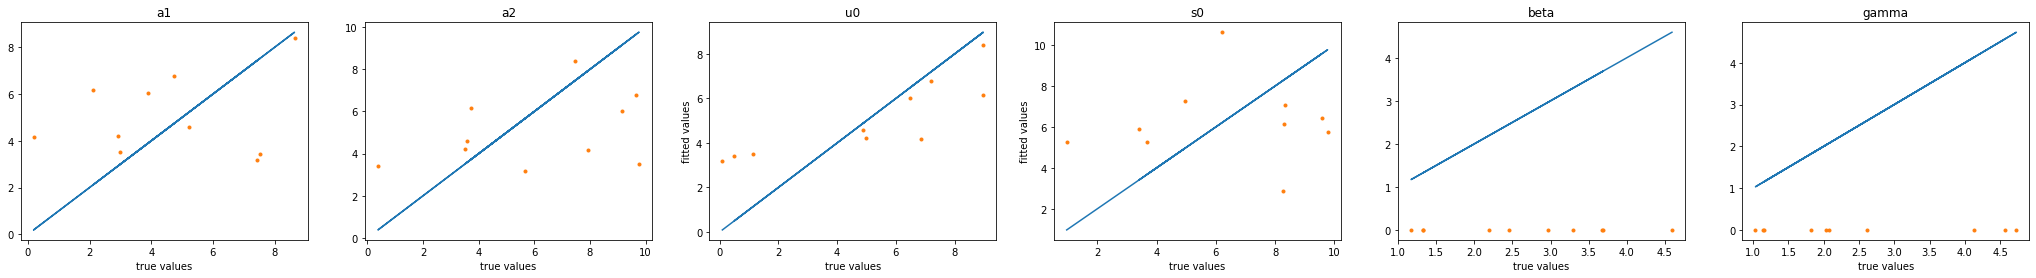

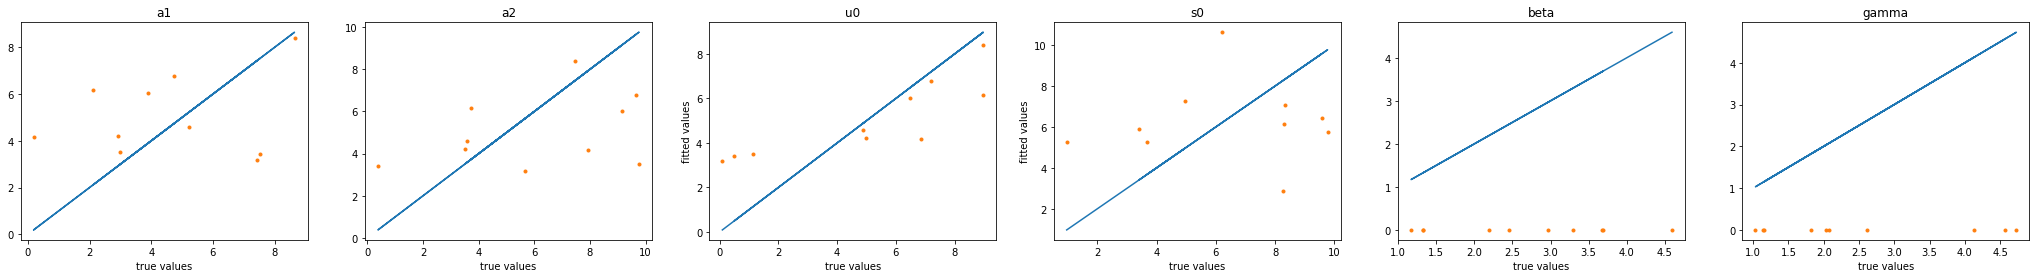

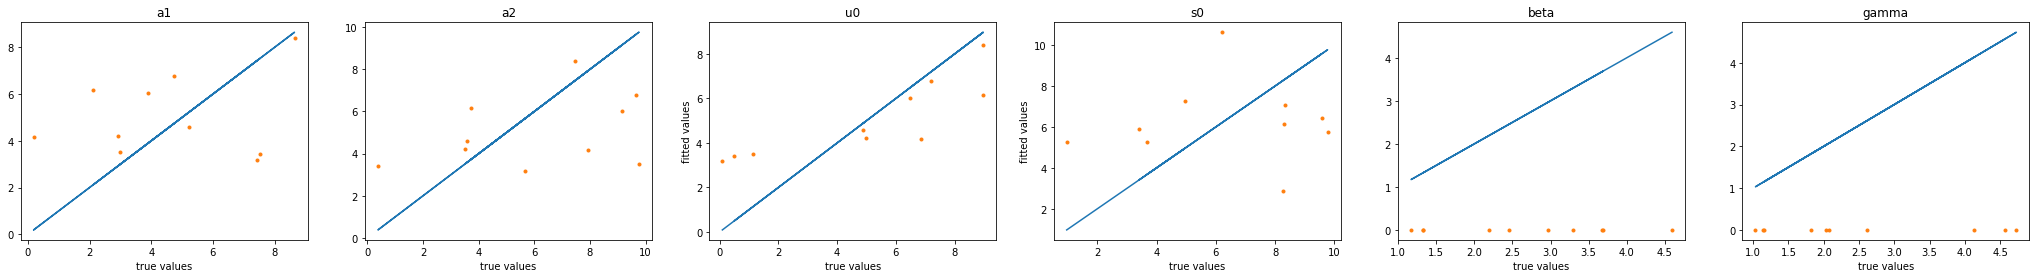

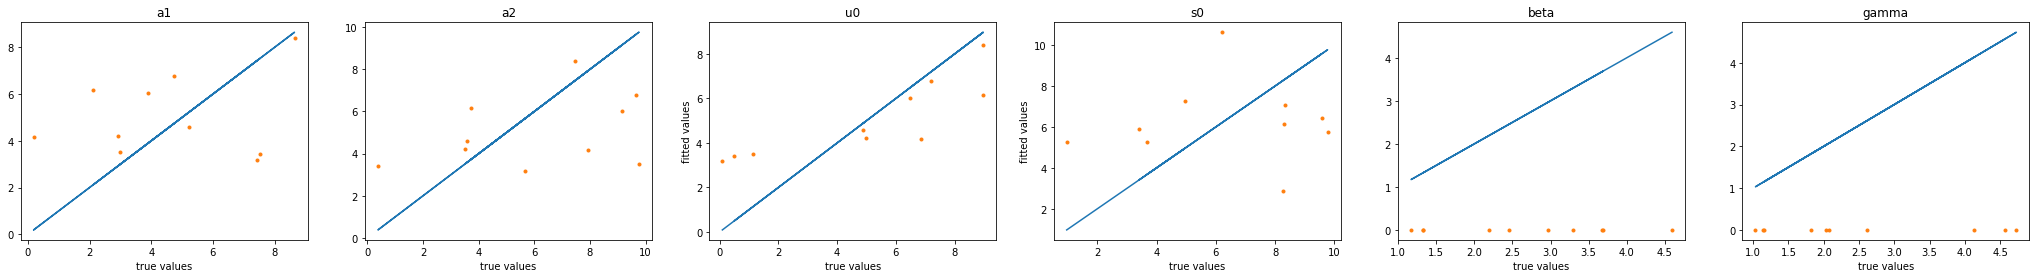

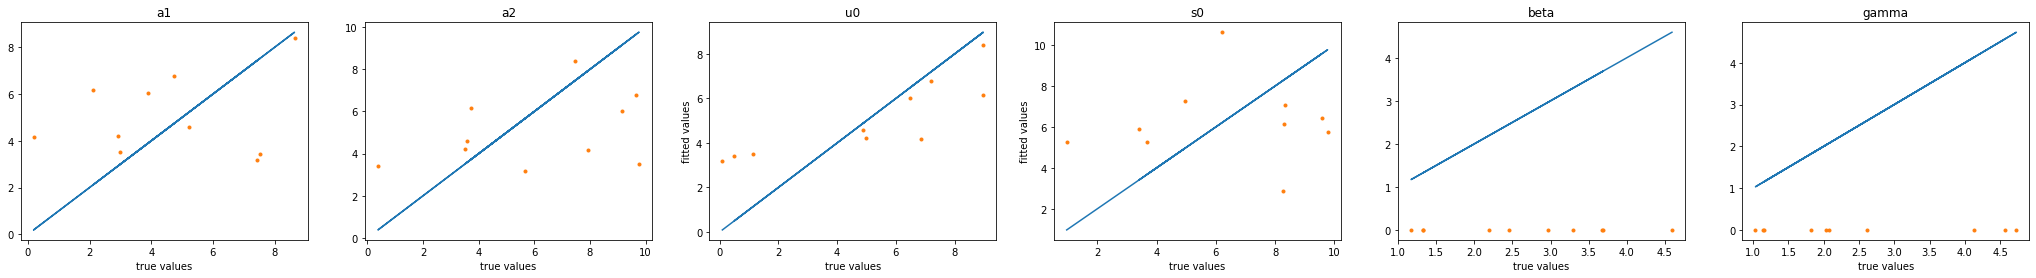

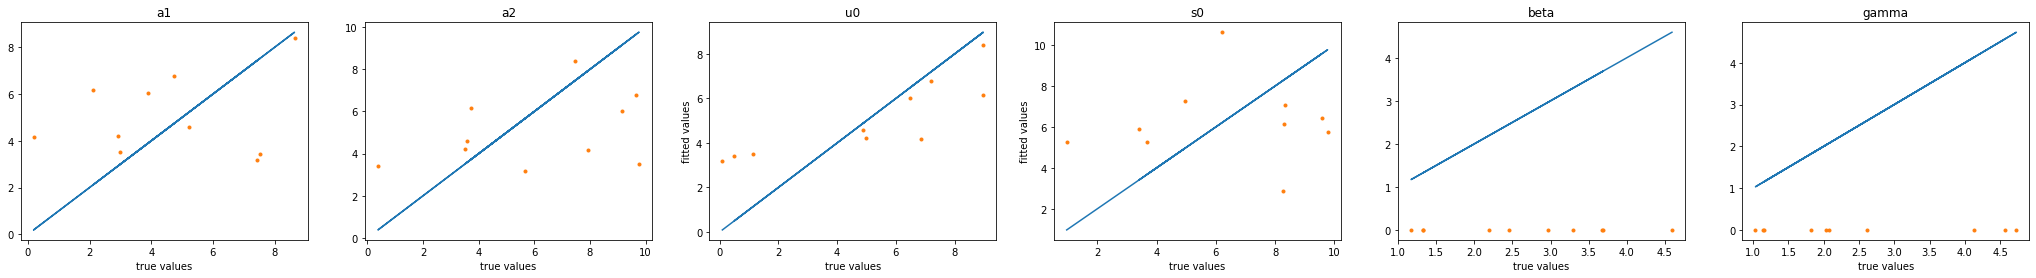

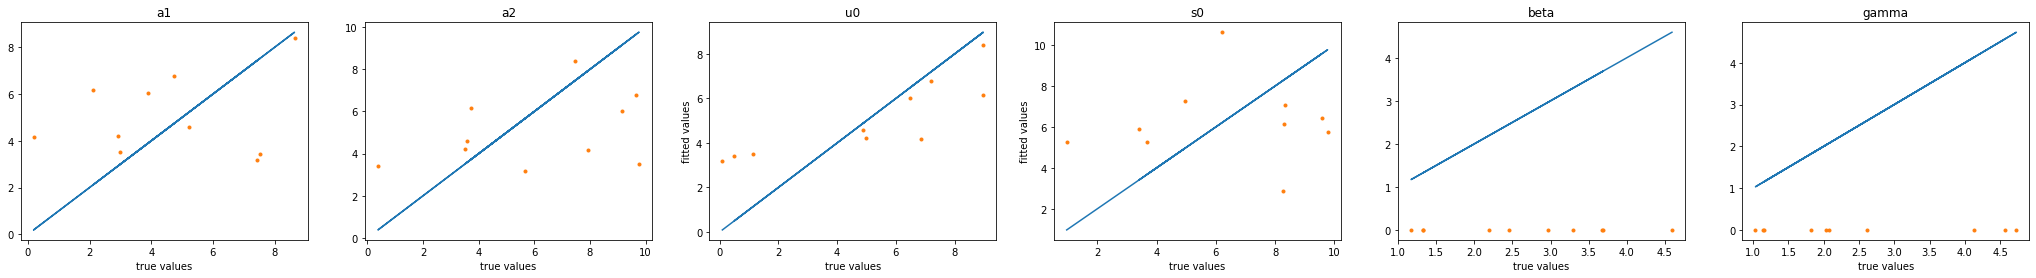

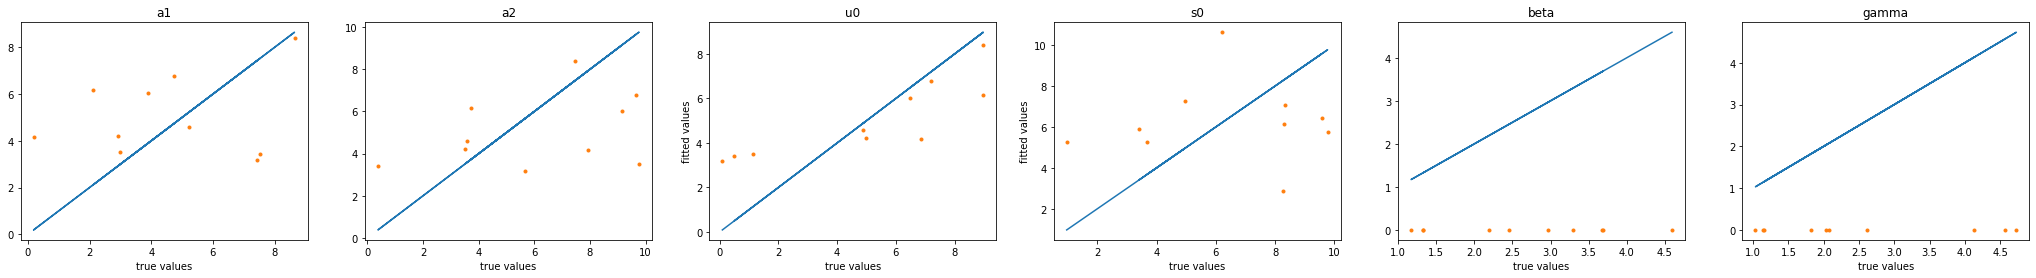

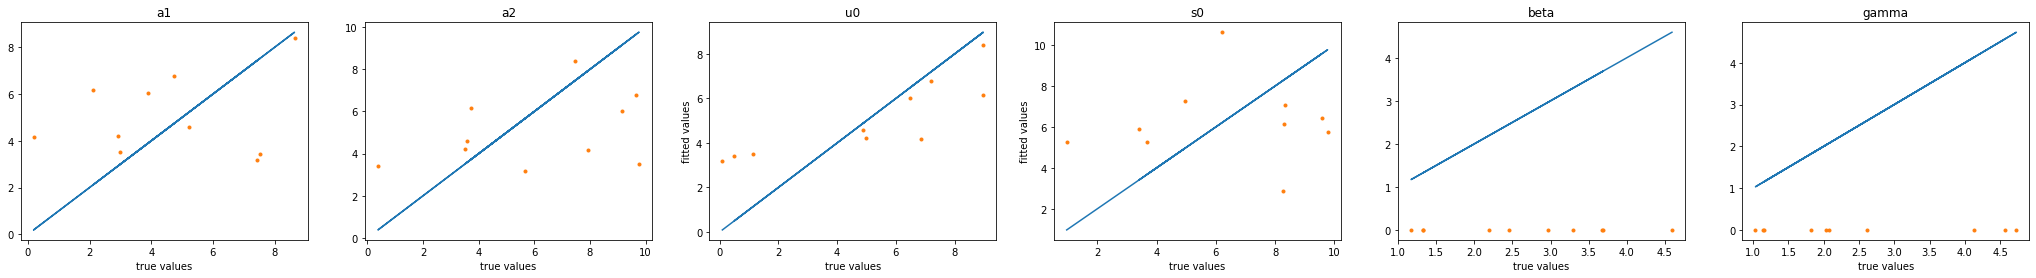

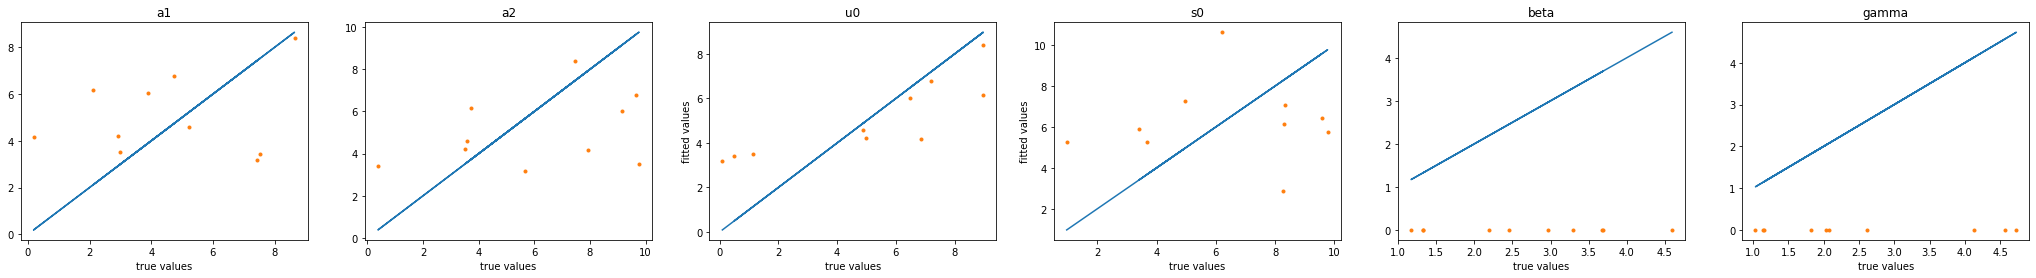

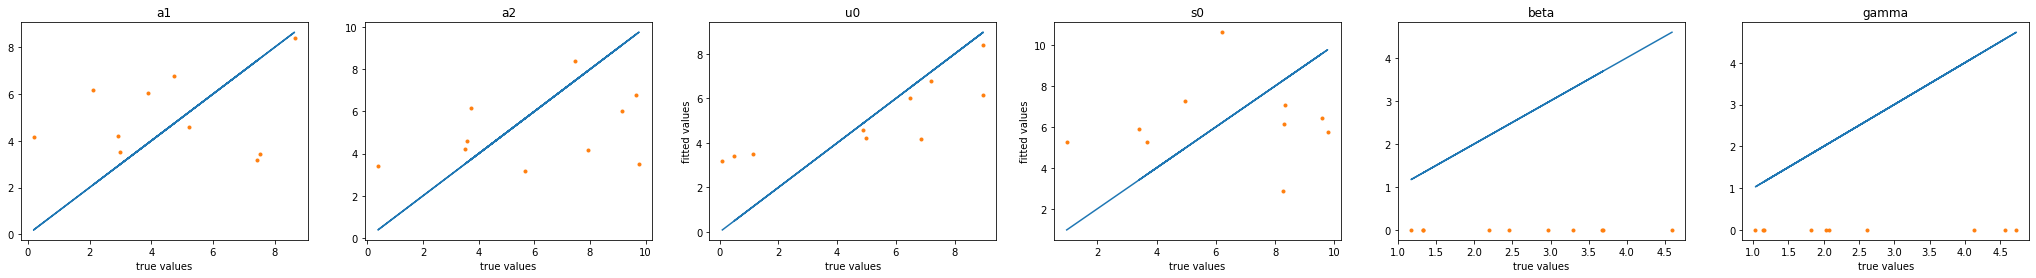

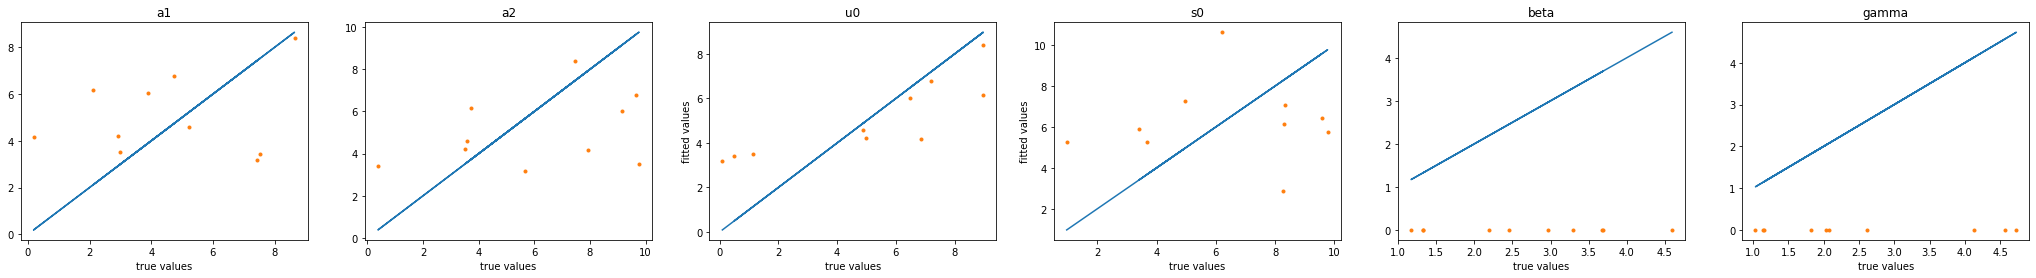

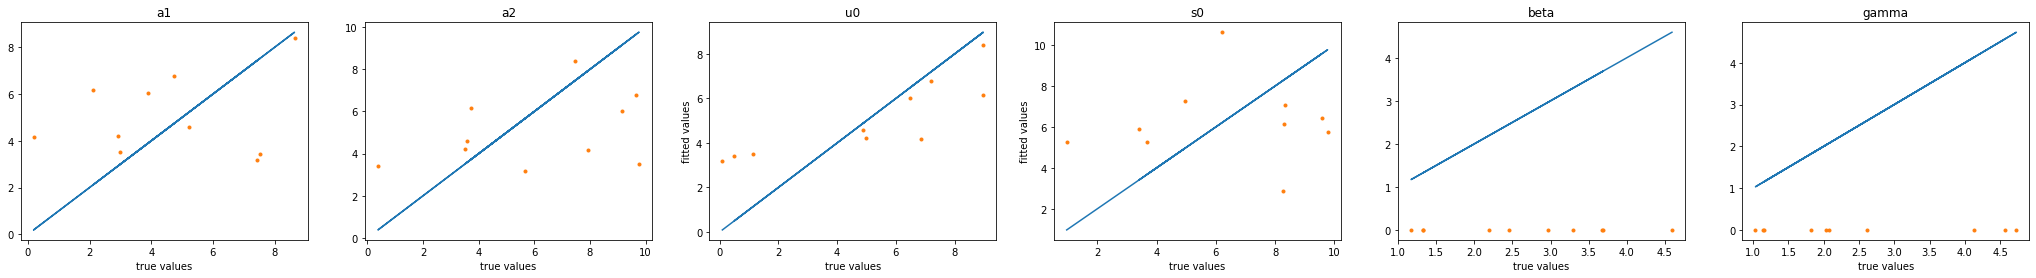

In [8]:
for i in range(20):
  plot_theta(theta,theta_hat_hist[i])

IndexError: ignored

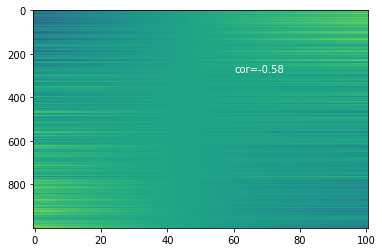

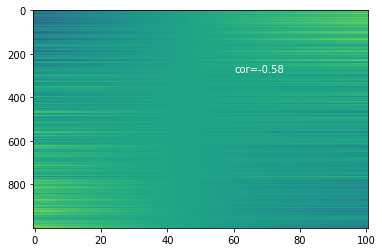

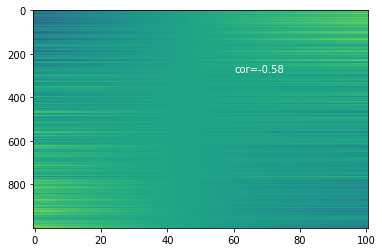

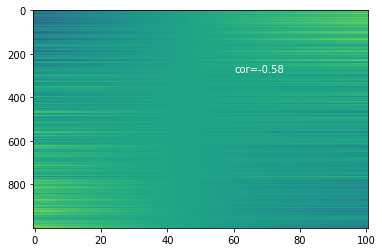

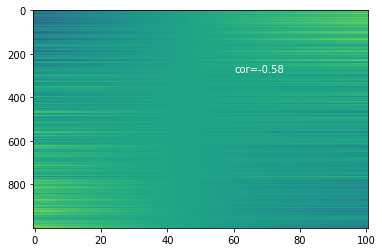

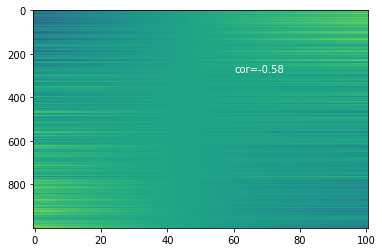

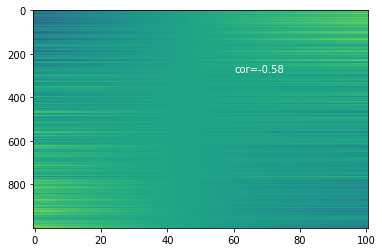

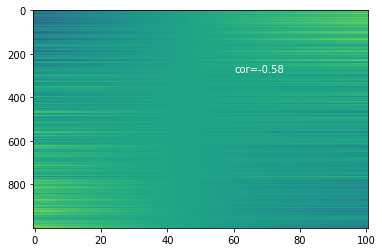

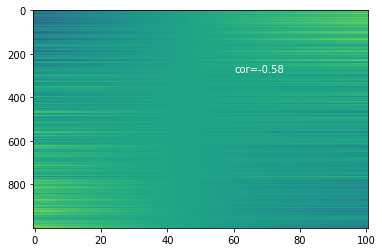

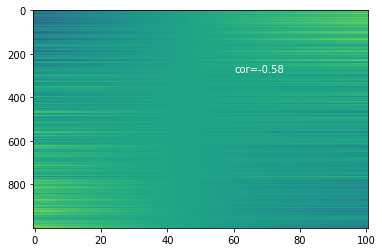

In [9]:
for i in range(20):
  plot_t(weight_hist[i],ax=None,t=t)

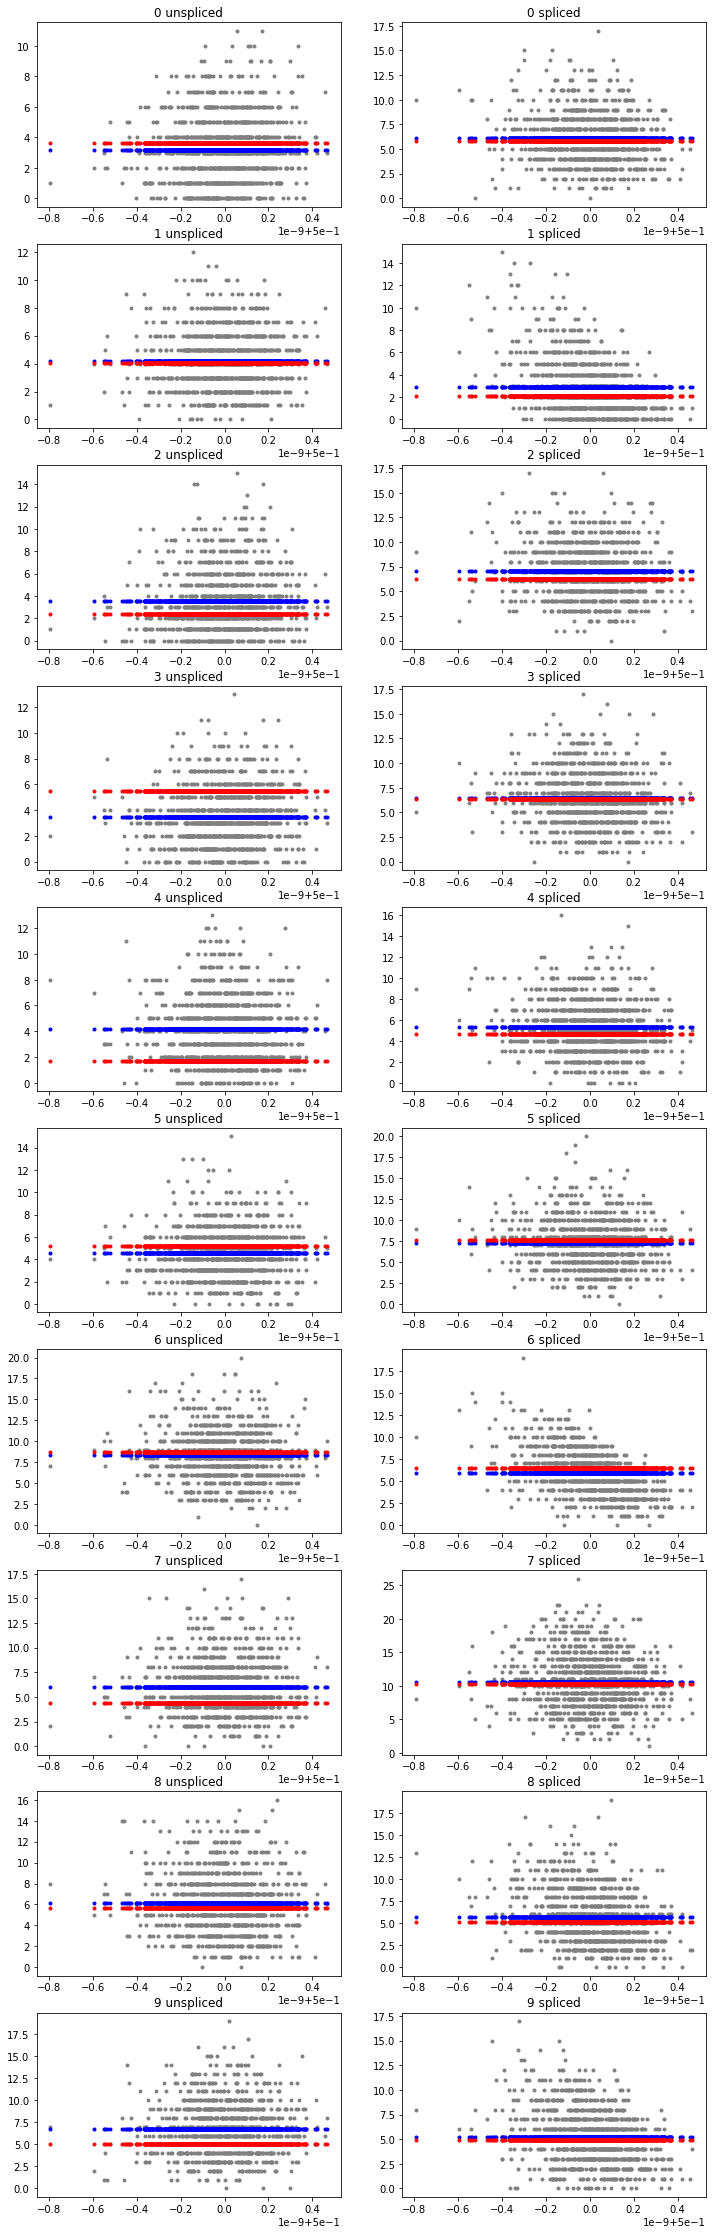

In [9]:
plot_y(theta,theta_hat_hist[-1],weight_hist[-1],tau,[str(i) for i in range(20)])

In [ ]:
#%% generate data
np.random.seed(2022)
n = 1500
p = 50
u0 = np.random.uniform(0,10,size=p)
s0 = np.random.uniform(0,10,size=p)
a1 = np.random.uniform(0,10,size=p)
a2 = np.random.uniform(0,10,size=p)
beta = np.random.uniform(1,5,size=p)
gamma = np.random.uniform(1,5,size=p)

t = np.linspace(0, 1, n)

Tau=[0,0.5]
tau=(0,0.5,1)

K=len(tau)-1
theta=np.zeros((p,K+4))
theta[:,0]=a1
theta[:,1]=a2
theta[:,-3]=s0
theta[:,-4]=u0
theta[:,-1]=gamma
theta[:,-2]=beta

Y = get_Y(theta,t,tau)

X = np.random.poisson(Y)

%time theta_hat, weight = traj_EM(X, tau, m=101, epoch=20, parallel = True, n_threads = 40)

100%|███████████████████████████████████████████| 20/20 [01:16<00:00,  3.81s/it]

CPU times: user 5.95 s, sys: 6.09 s, total: 12 s
Wall time: 1min 16s


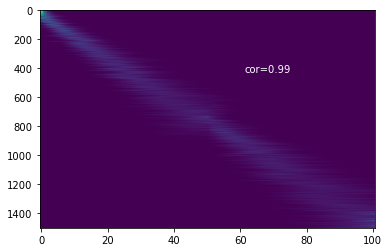

In [ ]:
plot_t(weight,ax=None,t=t)

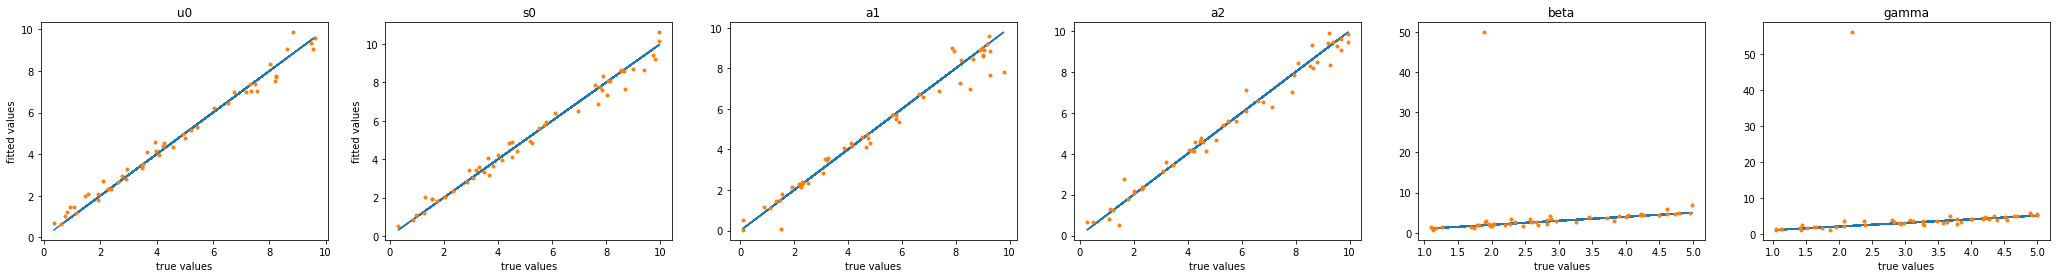

In [ ]:
plot_theta(theta,theta_hat,K)

## Requirement on n and p in optimal parameter regimes

An informative gene should have moderate beta and gamma value, not too small so that there are dynamics, and also not too large so that the dynamics are a significant part of data.

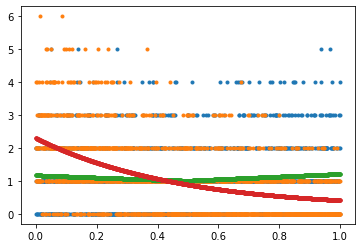

In [ ]:
p = 150
n = 1500
np.random.seed(2022)
t = np.linspace(0, 1, n)
tau=(0,0.5,1)
K=len(tau)-1
theta=np.zeros((p,K+4))
theta[:,0]=np.random.uniform(0,6,size=p)
theta[:,1]=np.random.uniform(0,6,size=p)
theta[:,-3]=np.random.uniform(0,6,size=p)
theta[:,-4]=np.random.uniform(0,6,size=p)
theta[:,-1]=np.random.uniform(0,3,size=p)
theta[:,-2]=np.random.uniform(0,3,size=p)

Y = get_Y(theta,t,tau)
X = np.random.poisson(Y)
plt.plot(t,X[:,0,],'.');
plt.plot(t,Y[:,0,],'.');

100%|███████████████████████████████████████████| 20/20 [23:55<00:00, 71.76s/it]


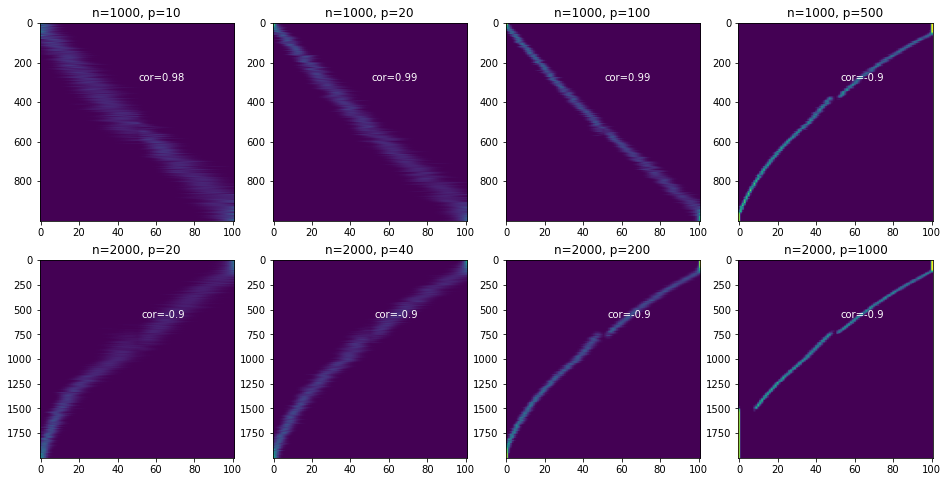

In [ ]:
ns=[1500,3000]
rs=[0.01,1/30,0.1]
np.random.seed(2022)
fig, axs = plt.subplots(len(ns), len(rs), figsize=(4*len(rs),4*len(ns)))
for i,n in enumerate(ns):
    for j,r in enumerate(rs): 
        p = int(n*r)
        t = np.linspace(0, 1, n)
        tau=(0,0.5,1)
        K=len(tau)-1
        theta=np.zeros((p,K+4))
        theta[:,0]=np.exp(np.random.uniform(0,6,size=p))
        theta[:,1]=np.exp(np.random.uniform(0,6,size=p))
        theta[:,-3]=np.exp(np.random.uniform(0,6,size=p))
        theta[:,-4]=np.exp(np.random.uniform(0,6,size=p))
        theta[:,-1]=np.random.uniform(1,5,size=p)
        theta[:,-2]=np.random.uniform(1,5,size=p)
        
        Y = get_Y(theta,t,tau)
        X = np.random.poisson(Y)

        theta_hat, weight = traj_EM(X, tau, m=101, epoch=20, parallel = True, n_threads = 40)

        plot_t(weight,axs[i,j],t)
        axs[i,j].set_title("n="+str(n)+", p="+str(p));

100%|███████████████████████████████████████████| 20/20 [00:45<00:00,  2.27s/it]


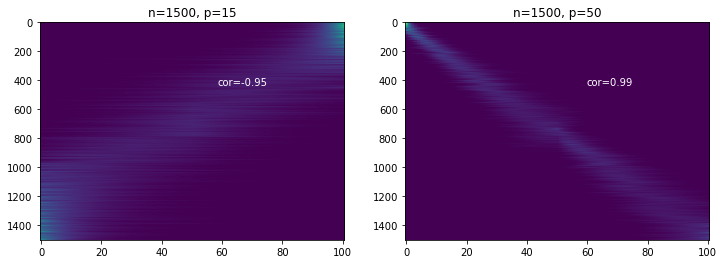

In [ ]:
ns=[1500]
rs=[0.01,1/30]#,0.02,0.1]
np.random.seed(2022)
fig, axs = plt.subplots(len(ns), len(rs), figsize=(6*len(rs),4*len(ns)))
for i,n in enumerate(ns):
    for j,r in enumerate(rs): 
        p = int(n*r)
        t = np.linspace(0, 1, n)
        tau=(0,0.5,1)
        K=len(tau)-1
        theta=np.zeros((p,K+4))      
        theta[:,-4]=np.random.uniform(0,10,size=p)
        theta[:,-3]=np.random.uniform(0,10,size=p)
        theta[:,0]=np.random.uniform(0,10,size=p)
        theta[:,1]=np.random.uniform(0,10,size=p)
        theta[:,-1]=np.random.uniform(1,5,size=p)
        theta[:,-2]=np.random.uniform(1,5,size=p)

        Y = get_Y(theta,t,tau)
        X = np.random.poisson(Y)

        theta_hat, weight = traj_EM(X, tau, m=101, epoch=20, parallel = True, n_threads = 40)

        plot_t(weight,axs[j],t)
        axs[j].set_title("n="+str(n)+", p="+str(p));

## What if we include some uninformative genes?

In [ ]:
ns=[1500,3000]
rs=[0.01,0.02,0.1,0.5]
np.random.seed(2022)
fig, axs = plt.subplots(len(ns), len(rs), figsize=(4*len(rs),4*len(ns)))
for i,n in enumerate(ns):
    for j,r in enumerate(rs): 
        p = int(n*r)
        t = np.linspace(0, 1, n)
        tau=(0,0.5,1)
        K=len(tau)-1
        theta=np.zeros((p,K+4))
        theta[:,0]=np.random.uniform(0,100,size=p)
        theta[:,1]=np.random.uniform(0,100,size=p)
        theta[:,-3]=np.random.uniform(0,100,size=p)
        theta[:,-4]=np.random.uniform(0,100,size=p)
        theta[:true_p,-1]=1 #10**np.random.uniform(0,1,size=p)
        theta[:true_p,-2]=1 #10**np.random.uniform(0,1,size=p)
        
        Y = get_Y(theta,t,tau)
        X = np.random.poisson(Y)

        theta_hat, weight = traj_EM(X, tau, m=101, epoch=20, parallel = True, n_threads = 40)

        plot_t(weight,axs[i,j],t)
        axs[i,j].set_title("n="+str(n)+", p="+str(p));

## Wrong tau

In [ ]:
#%% generate data
np.random.seed(2022)
n = 1500
p = 15
u0 = np.random.uniform(1,10,size=p)
s0 = np.random.uniform(1,10,size=p)
a1 = np.random.uniform(1,10,size=p)
a2 = np.random.uniform(1,10,size=p)
beta = np.random.uniform(1,5,size=p)
gamma = np.random.uniform(1,5,size=p)

t = np.linspace(0, 1, n)

tau=(0,0.5,1)
tau_hat=(0,0.7,1)

K=2
theta=np.zeros((p,K+4))
theta[:,0]=a1
theta[:,1]=a2
theta[:,-4]=u0
theta[:,-3]=s0
theta[:,-2]=beta
theta[:,-1]=gamma

Y = get_Y(theta,t,tau)

X = np.random.poisson(Y)

m=101
%time theta_hat, weight = traj_EM(X, tau_hat, m=101, epoch=20, parallel = True, n_threads = 2)

CPU times: user 2.45 s, sys: 1.09 s, total: 3.54 s
Wall time: 2min 18s


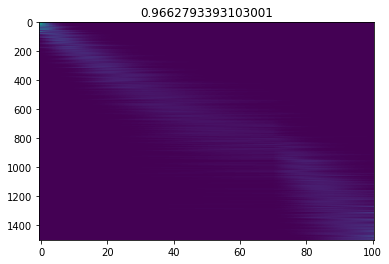

In [ ]:
plot_t(weight,t)

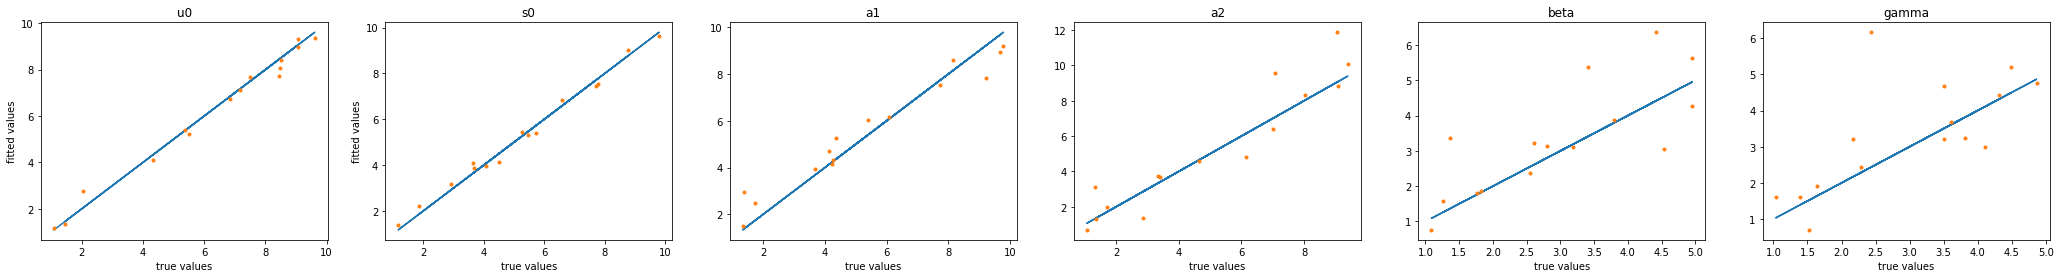

In [ ]:
plot_theta(theta,theta_hat,K)